In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-2/Dataset_2/t10k-labels-idx1-ubyte
/kaggle/input/dataset-2/Dataset_2/verification_train.csv
/kaggle/input/dataset-2/Dataset_2/t10k-images-idx3-ubyte
/kaggle/input/dataset-2/Dataset_2/verification_test.csv
/kaggle/input/dataset-2/Dataset_2/train-labels-idx1-ubyte
/kaggle/input/dataset-2/Dataset_2/train-images-idx3-ubyte


In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import ImageFile, Image
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset, Dataset
from mlxtend.data import loadlocal_mnist

In [13]:
training_images_filepath = '../input/dataset-2/Dataset_2/train-images-idx3-ubyte'
training_labels_filepath = '../input/dataset-2/Dataset_2/train-labels-idx1-ubyte'
test_images_filepath = '../input/dataset-2/Dataset_2/t10k-images-idx3-ubyte'
test_labels_filepath = '../input/dataset-2/Dataset_2/t10k-labels-idx1-ubyte'



In [14]:
X_train, y_train = loadlocal_mnist(training_images_filepath,training_labels_filepath)
X_test,y_test = loadlocal_mnist(test_images_filepath, test_labels_filepath)

In [17]:
print('training images size:', np.shape(X_train))
print('trainig labels size:',np.shape(y_train))
print('test images size:', np.shape(X_test))
print('test labels size:',np.shape(y_test))

training images size: (60000, 784)
trainig labels size: (60000,)
test images size: (10000, 784)
test labels size: (10000,)


In [18]:
X_train = X_train.reshape(60000, 28, 28)
X_test = X_test.reshape(10000, 28, 28)


print('training images:', np.shape(X_train))
print('test images:', np.shape(X_test))

training images: (60000, 28, 28)
test images: (10000, 28, 28)


In [19]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        pil_image = Image.fromarray(np.uint8(image)).convert('L')
        label = self.root[index]
        
        if self.transform is not None:
            image = self.transform(pil_image)
            
        return image, label

In [30]:
mean = [0.5,]
std = [0.5,]
train_transform = transforms.Compose([
                                      transforms.Resize(28),
                                      #torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
                                      #transforms.RandomRotation(20),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])
                                      ])

test_transform = transforms.Compose([
                                      transforms.Resize(28),
                                      #torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
                                      #transforms.RandomRotation(20),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])
                                     ])

train_data = Dataset(X_train, y_train, train_transform)
test_data = Dataset(X_test, y_test, test_transform)

print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))

Trainig Samples:  60000
Test Samples:  10000


In [31]:
BATCH_SIZE = 20

#train_set, test_set = torch.utils.data.random_split(dataset, [19438, 4860]) #80%
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Train Images: ",len(train_data))
print("Test Images: ",len(test_data))
print("Train Batch: ",len(train_loader))


# Hyperparameters
batch_size = 20
num_hidden = 200
num_iters = 20000
learning_rate = 0.01
input_dim = 28*28
output_dim = 10

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Train Images:  60000
Test Images:  10000
Train Batch:  3000
Tesla P100-PCIE-16GB


In [32]:
#DNN Model
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__() 
        
        self.fc1 = nn.Linear(input_size, num_hidden) 
        self.fc2 = nn.Linear(num_hidden, num_hidden) 
        self.fc3 = nn.Linear(num_hidden, num_hidden) 
        self.fc4 = nn.Linear(num_hidden, num_hidden) 
        self.fc5 = nn.Linear(num_hidden, num_hidden) 
        self.fc6 = nn.Linear(num_hidden, num_hidden) 
        self.out = nn.Linear(num_hidden, num_classes)
      
        #dropout to reduce overfitting
        #self.drop = nn.Dropout(0.25) 
        
        self.out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        x=x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.out(x)
        #x = self.drop(x)
        x = x
        return x

In [33]:
model = DNN(input_size=input_dim, num_classes=output_dim, num_hidden=num_hidden)
#Store in GPU
model.to(device)
print(model)

DNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)


In [34]:
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
stepcount = []
train_loss = []
train_loss2 = []
train_accuracy = []
test_accuracy = []
totalsteps = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        iter += 1
        #train_loss2 += loss.item()
        if iter % 100 == 0:  
            correct_test = 0
            total_test = 0

            for images, labels in test_loader:
                images = images.view(-1, input_dim).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                if torch.cuda.is_available():
                    correct_test += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct_test += (predicted == labels).sum()  

            accuracy_test = 100 * correct_test.item() / total_test

            train_loss.append(loss.item())
            test_accuracy.append(accuracy_test)
            
            totalsteps.append(iter)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy_test))
            accuracy_test = 0

Iteration: 100. Loss: 2.300567626953125. Accuracy: 10.0
Iteration: 200. Loss: 2.3090219497680664. Accuracy: 10.0
Iteration: 300. Loss: 2.2946534156799316. Accuracy: 18.57
Iteration: 400. Loss: 2.304583787918091. Accuracy: 19.47
Iteration: 500. Loss: 2.2986464500427246. Accuracy: 19.34
Iteration: 600. Loss: 2.3006365299224854. Accuracy: 13.82
Iteration: 700. Loss: 2.296496629714966. Accuracy: 16.47
Iteration: 800. Loss: 2.2932615280151367. Accuracy: 24.04
Iteration: 900. Loss: 2.2970869541168213. Accuracy: 30.37
Iteration: 1000. Loss: 2.2886955738067627. Accuracy: 26.27
Iteration: 1100. Loss: 2.289982318878174. Accuracy: 30.77
Iteration: 1200. Loss: 2.2456793785095215. Accuracy: 32.06
Iteration: 1300. Loss: 2.261660575866699. Accuracy: 27.84
Iteration: 1400. Loss: 2.175689458847046. Accuracy: 25.23
Iteration: 1500. Loss: 2.0516884326934814. Accuracy: 23.17
Iteration: 1600. Loss: 1.8908212184906006. Accuracy: 27.11
Iteration: 1700. Loss: 1.854836106300354. Accuracy: 27.13
Iteration: 1800

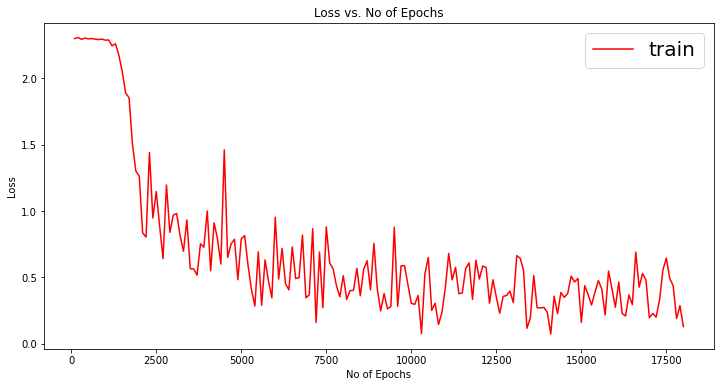

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title("Loss vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.plot(totalsteps, train_loss,'r-', label="train")
#plt.ylim((2.2,2.4))
plt.legend(prop={'size': 20}, loc='upper right')

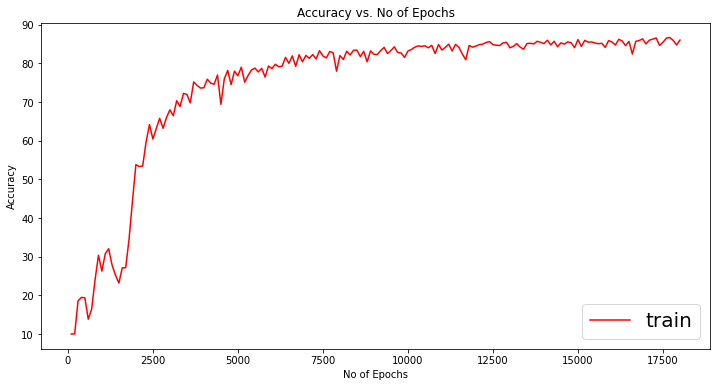

In [43]:
plt.figure(figsize=(12,6))
plt.title("Accuracy vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.plot(totalsteps, test_accuracy,'r-', label="train")
#plt.ylim((5,15))
plt.legend(prop={'size': 20}, loc='lower right')
plt.show()

In [37]:
%cd /kaggle/working

/kaggle/working


In [38]:
Path='./T2_EX1.pkl'
pt = './T2_EX1.pth'
torch.save(model.state_dict(), Path)
torch.save(model.state_dict(), pt)

In [44]:
BATCH_SIZE = 64

#train_set, test_set = torch.utils.data.random_split(dataset, [19438, 4860]) #80%
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Train Images: ",len(train_data))
print("Test Images: ",len(test_data))
print("Train Batch: ",len(train_loader))



Train Images:  60000
Test Images:  10000
Train Batch:  938


In [45]:
# Hyperparameters
batch_size = 64
num_hidden = 784
num_iters = 100000
learning_rate = 0.05
input_dim = 28*28
output_dim = 10
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [46]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__() 
        
        self.fc1 = nn.Linear(input_size, num_hidden) 
        self.fc2 = nn.Linear(784, 512) 
        self.fc3 = nn.Linear(512, 256) 
        self.fc4 = nn.Linear(256, 256) 
        self.out = nn.Linear(256, num_classes)
      
        #dropout to reduce overfitting
        #self.drop = nn.Dropout(0.25) 
      

    def forward(self, x):
        x=x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        #x = self.drop(x)

        return x

In [47]:
model = DNN(input_size=input_dim, num_classes=output_dim, num_hidden=num_hidden)
#Store in GPU
model.to(device)
print(model)
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

DNN(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [48]:
stepcount = []
train_loss = []
train_loss2 = []
train_accuracy = []
test_accuracy = []
totalsteps = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        iter += 1
        #train_loss2 += loss.item()
        if iter % 100 == 0:  
            correct_test = 0
            total_test = 0

            for images, labels in test_loader:
                images = images.view(-1, input_dim).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                if torch.cuda.is_available():
                    correct_test += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct_test += (predicted == labels).sum()  

            accuracy_test = 100 * correct_test.item() / total_test

            train_loss.append(loss.item())
            test_accuracy.append(accuracy_test)
            
            totalsteps.append(iter)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy_test))
            accuracy_test = 0

Iteration: 100. Loss: 1.6502043008804321. Accuracy: 39.11
Iteration: 200. Loss: 0.9209191799163818. Accuracy: 67.66
Iteration: 300. Loss: 0.6853259205818176. Accuracy: 69.55
Iteration: 400. Loss: 0.7123910188674927. Accuracy: 74.69
Iteration: 500. Loss: 0.7263659238815308. Accuracy: 77.76
Iteration: 600. Loss: 0.5149998068809509. Accuracy: 77.67
Iteration: 700. Loss: 0.4500676393508911. Accuracy: 78.81
Iteration: 800. Loss: 0.5117031335830688. Accuracy: 81.8
Iteration: 900. Loss: 0.3314371407032013. Accuracy: 81.8
Iteration: 1000. Loss: 0.42728203535079956. Accuracy: 82.28
Iteration: 1100. Loss: 0.4198192358016968. Accuracy: 82.98
Iteration: 1200. Loss: 0.36108383536338806. Accuracy: 82.59
Iteration: 1300. Loss: 0.5464728474617004. Accuracy: 81.41
Iteration: 1400. Loss: 0.5509127974510193. Accuracy: 81.27
Iteration: 1500. Loss: 0.4115597605705261. Accuracy: 82.6
Iteration: 1600. Loss: 0.4036203622817993. Accuracy: 83.64
Iteration: 1700. Loss: 0.4555189907550812. Accuracy: 83.79
Iterati

KeyboardInterrupt: 

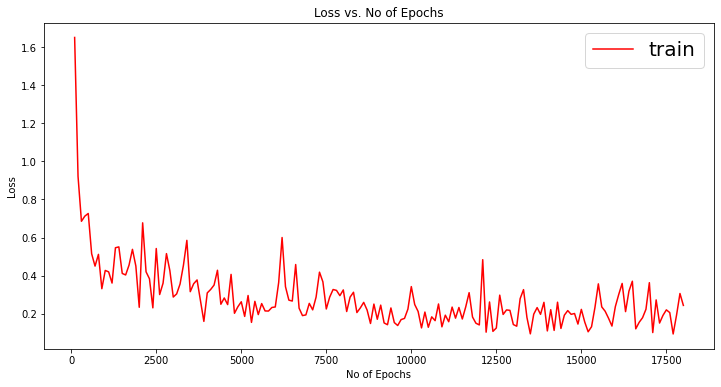

In [49]:
plt.figure(figsize=(12,6))
plt.title("Loss vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.plot(totalsteps, train_loss,'r-', label="train")
#plt.ylim((2.2,2.4))
plt.legend(prop={'size': 20}, loc='upper right')

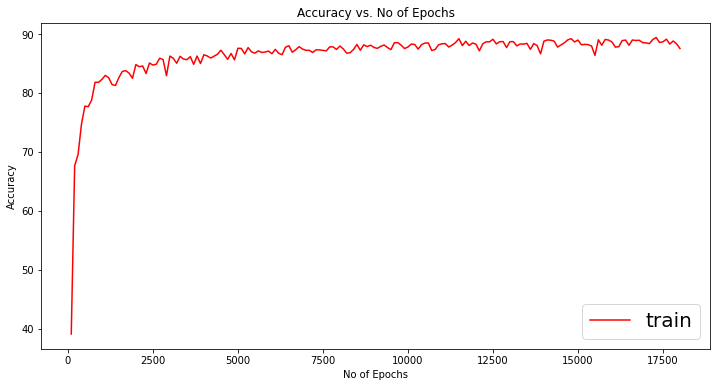

In [50]:
plt.figure(figsize=(12,6))
plt.title("Accuracy vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.plot(totalsteps, test_accuracy,'r-', label="train")
#plt.ylim((5,15))
plt.legend(prop={'size': 20}, loc='lower right')
plt.show()